# Abstract
Arctic new particle formation is an import source of cloud condensation nuclei which in turn affect cloud properties. Insights into the drivers of new particle formation in a changing climate are important, as clouds in the Arctic contributes to further warming of an already vulnerable environment. Sea ice decline has been observed to be correlated with increasing new particle formation at the Zeppelin Observatory, but the underlying processes are complex, and the question is whether this hold true for more recent years. In this work, DMPS and CPC data from Zeppelin between 2010-2020 as well as satellite data on sea ice and chlorophyll concentration. The correlation between new particle formation and sea ice is investigated and different methods are tested to identify a suitable indicator for detection of new particle formation in the size distribution data. K-means cluster analysis was chosen to best represent the which partitions the data into $k$ clusters based on the shape of the size distribution. The results suggest that there is no correlation between the annual new particle formation frequency and sea ice concentration in the Greenland and Barents Sea for the years 2010-2017, which differs from previous observations at Zeppelin between 2000-2010. Further investigations targeting for example air mass trajectory analysis and suitable new particle formation indicators are needed to obtain amore complete understanding of the complex interplay between new particle formation drivers. 

# Acknowledgements

First and foremost, I would like to acknowledge the providers of the data sets OSI-SAF consortium (sea ice data) and OBS-ESACCI-OC for chlorophyll data, and the Norwegian Polar Institute (NPI) for running the Zeppelin station and EBAS for managing the database. 

I collaborated with Kei Tsuruhara and our supervisor Dominic Heslin-Reese. I am very thankful to be part of this team, it has been inspiring (and fun!) to work with them. In this report Kei has produced the sea ice data (it was not easy to work with that dataset!), Dominic provided the DMPS and CPC data as well as some functions to read in and do the basic preparation of data. Other than I have received tremendous amount of help while learning Python (and data analysis in general) from especially Dominic but also from other course instructors. Thanks Paul Zieger for enthusiasm and great advices on things to look more into. Thanks to Linn Karlsson whose work in a previous version of this course happened to include a great function to integrate log-normal distributions.


# Introduction

The Arctic has experienced a much faster warming than other part of the globe. The response to increased temperature in the Arctic environment is manyfold and implies drastic changes to of the whole environment and ecosystems. Drastic reductions in sea ice cover (Perovich et al., 2018) occurs oceans are becoming more productive which implies increased emissions new particle formation precursor gases (Galí et al. 2019). New particle formation (NPF) play an important role in the Arctic radiation budget as the may grow to cloud condensation nuclei’s (CCN:s) and subsequently activate into cloud droplets. Clouds exert a net warming effect in the Arctic, which makes studies of NPF drivers important. 

The Arctic is in many ways an extreme environment which is also reflected in the annual cycle of airborne particulate matter (Tunved et al. 2013). During the dark months, ocean and air circulation patterns implies an influx of anthropogenic pollutants, and the aerosol size distribution is dominated by accumulation mode particles. In combination with the Arctic wintertime meteorological conditions, this leads to the formation of a persistent Arctic haze. As the sun gradually returns, the circulation and airmass transport patterns changes and the anthropogenic pollution inflow is restricted. Formation of low-level clouds during summertime leads to removal of accumulation mode particles by wet scavenging marks the end of the Arctic Haze period. Consequently, the composition, properties, and size distribution of Arctic aerosol particle change. The lower aerosol load and increased availability of sunlight promotes photochemistry and results in a peak of in aerosol particles smaller than 100 nm (Schmale & Baccarini, 2021).

At the Zeppelin mountain station on Svalbard long-term measurements are conducted to monitor the properties of aerosol particles. Long term measurements are valuable to monitor changes of the sensitive Arctic environment. Data from eleven years of DMPS measurements (2000-2010) at the Zeppelin station have been used to present the hypothesis that Arctic sea ice reduction leads to increased NPF frequency at Zeppelin (Dall'Osto et al. 2017). The question this project makes an attempt to answer is weather this is a causal effect, if this hold true for subsequent years and if trends in proxies for productivity of oceans might be driving NPF as well. Another aim is to partly reproduce the Dall'Osto paper for a later time period by applying similar methodology with regards to NPF identification in the DMPS data, as well as to investigate other possibilities for NPF identification. We will use satellite data on sea ice and chlorophyll, and aerosol size distribution and number concentration data from Zeppelin.


# Method

## Datsets

We have used level 2 Differential Mobility Particle Sizer (DMPS) and data from two different Condensation particle counters (CPC's) from the Arctic Zeppelin mountain station at Svalbard, provided by our supervisor Dominic Heslin-Rees, and satellite retrieved sea ice concentration from OSI-SAF and satellite chlorophyll observations OBS-ESACCI-OC. The DMPS and CPC data encompass the years 2010-2020 with overall high data coverage. The data was supplied in 30 min resolution. The satellite data was processed Kei and DMPS and CPC data is the focus of this report. 

The DMPS measures the particle number size distributions for particles smaller than 1000 nm. The DMPS scans over different sizes and measures the number concentration (#/cm$^3$) in each size interval, or bin. The output is in the form of log normal particle concentration which accounts for the difference bin bin width. (CPC's) simply counts particles in the sub micrometer range and provides the particle number concentration (#/cm$^3$).
 

## Import packages

And make sure that functions are auto-updated.

In [1]:
import DMPS_functions as fu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import seaborn as sns
import scipy as sc
import glob 
import sklearn.metrics as skm
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
import scipy.stats as st
import seaborn as sns
from matplotlib import cm

# Auto-update the functions. Useful if the functions have been altered. 
%load_ext autoreload
%autoreload 2

plt.rcParams['font.size'] = '12'

In [2]:
# Defining the path containg all DMPS data
path = 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\'

In [3]:
# Using glob to import the files in the specified path
fu.importData(path)

Loading each year of 30 min resolution DMPS data into a dataframe and create a list containing all dataframes.
Column headings are added, and data flagged as invalid is removed.

In [4]:
DFs_DMPS = fu.load_and_append_DMPS(path, 
                             name_in_file='DMPS')

## Concatenate DMPS data 
The DMPS data comes in several files and must be concatenated into a common dateframe, and unessary columns are dropped.

In [5]:
df_DMPS = fu.concat_df_DMPS(DFs_DMPS)

Useful variables are defined column headings renamed to ease calling of specific columns.

In [6]:
# Get a list with the DMPS bin column names as strings and floats to call column in dataframe and for calculations.
bin_col_list = fu.get_bin_column_string_list()
bin_cols = fu.get_bins(bin_col_list)
bin_cols = [float(x) for x in bin_cols]

# Rename the column headings for midpoint diameters to numeric values with less decimals.
df_DMPS = fu.renameDpColumns(df_DMPS, bin_col_list)

# Make a list of all the "real" non-rounded midpoint diameters as a list and as array.
diameterList, diameters = fu.getFloatDiameterListAndArray()

# Make a list of diameters as string-objects
diameters_as_strings = [str(x) for x in diameters]

## Resampling to hourly averages 
The function ``resample`` was used to convert the 30 min DMPS particle size distribution data to a dataframe containing the 1 hour average. The python function ``resample`` fills the gaps in the data by adding rows for gap days/months/hours with NaN-values to get a continous dataset. Because of this, rows containing only NaN values are dropped. 

In [7]:
df_hourly_2010_2020_mean  = df_DMPS.resample('H').mean()
df_hourly_2010_2020_mean  = df_hourly_2010_2020_mean.dropna(how='all')

The first two columns in the dataframe contain data from two different CPC:s, i.e. condensation particle counters which count particles and yield the particle concentration in #/cm$^3$. The UFCPC (ultrafine CPC) has a lower particle diameter threshold at 3 nm in comparision with the CPC3010 whose lower threshold is at 10 nm. The third colum Ntot contains the total particles number concentration as computed by the DMPS. The rest of the columns specify the midpoint size (nm) of the bins for which the values indicate the log-normal distribution (#/cm$^3$). The last column (not visable indicates flags indicating the validity of the data. Unvalid data was removed by ``concat_df_DMPS`` function.   

## Identifying NPF events

One aims of this report is to conduct a brief investigation of different methods to identify NPF events. Some different methods are tested to identify the NPF events:

* By calculation of $\frac{N_{D_p<10nm}}{N_{tot}}$ 
* By using K-means clustering
* By calculating the difference between the UFCPC and the CPC 

Below the methods are decribed in more detail.

### Method 1: Using $N_{D_P <x}/N_{tot}$ 

The motivation to use the first metod is that in the event of NPF, there will by a drastic increase in number concentration of particles in smallest size bins, and the ratio of particles in the smaller bins to should be elevated. The first method requires that the total number concentration $N_{tot}$ is calculated in a given diameter range. To do this, the log-normal distribution which is provided by the DMPS has to be integrated. Linn Karlsson (e-Science course participant 2017) should be acknowledged for great inspiration to the method used in this work (Linn's method invloved the use of dictionaries but here arrays are used instead).  

The ``calcNtot`` calculates the particle concentration by integrating in a given bin midpoint diameter interval ``diameters`` and adds a column in the returned dataframe containg the calculated values.

In [8]:
# Calculate the total particle number concentration for the 1 h resolution data
df_hourly_2010_2020_mean_ntotCalc  = fu.calcNtot(diameters, df_hourly_2010_2020_mean,diameters_as_strings) 

In Figure 1, the result from the integration of the full size distribution is compared to Ntot given in the DMPS data, and they appear to be in good aggrement (slope of 1 and $R^2$ close to 1).

R-squared: 0.999363
Intercept: 0.0445901316076629
Slope: 1.0004705430431775


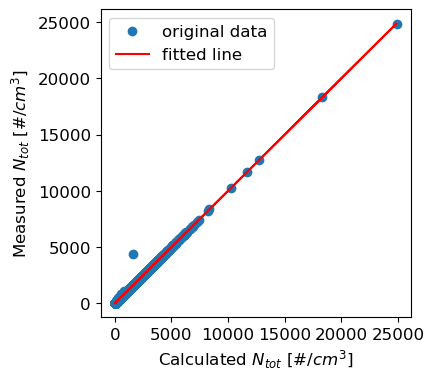

In [9]:
varx = df_hourly_2010_2020_mean_ntotCalc['NtotCalc'].values
vary = df_hourly_2010_2020_mean_ntotCalc['Ntot'].values

fu.compareIntegration(varx,vary)

**Figure 1. Comparison of the integrated total particle number concentration and the total particle number concentration given by the DMPS.**

### Method 2: K-means clustering

The second approach to identify NPF events involves K-means clustering (using ``sklearn.cluster.Kmeans``) of the long-term DMPS dataset which is an unsupervised machine learning algorithm. In short, unsupervised machine learning as opposed to supervised, involves data without labels and the data is grouped based in similarity of the data. This approach was previously deployed by Dall'Osto et al. (2017) to identify NPF events from size distribution data at the Zeppelin, and therefore it is interesting try the same approach. Clustering of data implies grouping similar objects together based on different features of the data. The K-means algorithm means that the data is divided into to a user defined number of cluster ($k$). The K-means algorithm starts by picking k random datapoints and assigns them as centers of the cluster (centroids). Then distance of the other data points to the centroids are then calculated and they are assigned to the nearest cluster centroid. Then the process of assigning new centroids starts over and the data is reassigned. This process is then repeated several times until the final clusters are established.  

Following the approach of Dall'Osto et al. (2017), we cluster according to the shape of the distribution. Prior to applying the K-means clustering the size distribution data must therefore be normalized, and the optimal numbers of clusters needs to be determined. 

In [10]:
df3, df_daily_2010_2020_1h_mean_norm = fu.create_normalised_df(df_hourly_2010_2020_mean)

For the hourly averaged data some endpoint columns where dropped in order for the clustering to work. Apparently the K-means method was very sensitive to the (in most cases) low concentrations in the endpoints. This might indicate that the clustering method is not too robust. Normally particle number concentrations are low in the end bins, and by dropping them it is reasonable to assume that the overall size distribution shape should be preserved.  

In [11]:
df_hourly_norm_dropped = df_daily_2010_2020_1h_mean_norm.copy()
df_hourly_norm_dropped = df_hourly_norm_dropped.drop \
                         (columns=['norm5.012','norm630.957','norm707.946'])

#### Optimizing the number of clusters 

This potentially introduces some doubt whether it actually is NPF events that the clustering captures or maybe the cluster analysis is a better proxy for seasonal variation in the size distribution, or presence of ultrafine particles in general.
The optimal cluster number *k* for K-means clustering needs to be decided upon. This could be done using several methods. Here the inertia method and the average silhouette score is used. 

The inertia method implies calculating the mean squared distance of each clusters to its nearest centroid. As a rule of thumb, a good clustering model has a low inertia and low number of clusters. If *k* equals the number datapoints, the inertia equals zero, so while choosing the optimal *k* there is a tradeoff between inertia and number of clusters. To find the optimal *k* the elbow in the inertia vs $k$ is identified, where the increase in *k* implies a slower decrease in inertia. 

The Silouette score generates a number between -1 and 1. The closer the Silouette score is to 1, the better cluster are distinguished from each other. A score of 0 implies that clusters are not well distinguished and -1 that clusters are wrongly assigned. Here, the average silouette score is computed which informs on the average separation of all clusters. Ideally the Silouette score is calculated for individual samples as well (out of the scope of this work) to optimize the choice of *k*.

Optimization was done for varying *k* between 2 and 13 clusters.


In [12]:
#fu.optimizeClusters(df_hourly_norm_dropped)   

**Figure 2. The inertia (left y-axis) and average silohouette score (right y-axis) versus the number of clusters.**

From the inertia method it is not straightforward to define the elbow, where adding more clusters results in a minor decrease of inertia. It is clear that the average silhoutette score of the clusters decrease with increasing number of clusters.

The optimal cluster number was here decided to *k* = 5, rather than 4 as inertia decrease less for each added cluster when *k* > 4. Six clusters did not improve the silouette score and five clusters is preferred over seven as inertia is higher when *k* = 5. 

#### Method 3: Utilizing the different CPC's 
The last method to identify the NPF events involves taking advantage of the different detection limits of the UFCPC (3 nm) and CPC3010 (10 nm) that was provided in the dataset in addition to the DMPS data. Two different approaches where tested: taking the absolute difference between the instruments and by computing the ratio of measured concentrations.


# Results

## K-means clustering 

The clustering was performed using $k$ = 5 clusters. 

In [13]:
# Optimal cluster number 
n_clusters = 5

#Perform K-means clustering
silhouette_avg_1h, inertia1h, df_norm_clustered_1h_mean = fu.perform_clustering(df_hourly_norm_dropped, n_clusters)

# Define the unique number of size distribution clusters in the sence that peak diameter is different.
clusters = np.unique(df_norm_clustered_1h_mean['clusters'].values)

# Check that the number of clusters resulting from the clustering procedure is equal to the variable ``n_clusters``, 
# i.e. that the peak diameters of the clustered size distributions are unique. Print result.
fu.checkUniqueModeDiam(df_norm_clustered_1h_mean,n_clusters)

OK! Clusters peak for different diameter when number of clusters =  5


Each hourly distribution was assigned a cluster ID during the clustering. The mean, standard devitation, median, 10- and 90-percentiles of the clustered data was calulated for each cluster in order to visulize the results of the clustering procedure. 

In [14]:
df_norm_clustered_1h_mean_median = df_norm_clustered_1h_mean.groupby('clusters').median()
df_norm_clustered_1h_10q         = df_norm_clustered_1h_mean.groupby('clusters').quantile(.1)
df_norm_clustered_1h_90q         = df_norm_clustered_1h_mean.groupby('clusters').quantile(.9)

df_norm_clustered_1h_mean_mean   = df_norm_clustered_1h_mean.groupby('clusters').mean()
df_norm_clustered_1h_std         = df_norm_clustered_1h_mean.groupby('clusters').std()

Below, the mean +/- 1$\sigma$ (shaded area) of the normalized and clustered size distribution data is shown. The median is plotted as a dotted line for comparison. From the graph it is clear that median and mean are similar. From this we drew the conclusion that cluster 1 and 2 may represent NPF events, although both 1 & 2 are bimodal and extends to the accumulation mode. Varying the cluster number did not remove the bimodality for the clusters whose normalized distributions peak occurs for $D_p$ < 100 nm. Moreover, clustering mean and median daily distributions using 5 clusters displayed high similarity with the clusters shown below (daily clustering is not shown here).  

Comparing the results of our clustering analysis with that of Dall'Osto et al. (2017) and their daily mean clusters a few qualitative observations could be made. Firstly, two of the clusters classified as NPF indicators nucleation or bursting by Dall'Osto et al. (2017) which peak at 10 nm or lower, are most similar to our cluster 1 (however, their data was not normalized, nor were clusters plotted alongside each other which may make absolute comparison difficult).These clusters also have tails extending into the accumulation mode although the bimodality is absent or not as pronounced in our hourly (nor daily or median) clusters. It should also be mentioned that their third NPF indicator cluster (nascent) partly show similarity with our cluster 3 on the left hand side of the peak, although our cluster 3 appear to be a superposition of two modes and therefore we disregarded this cluster as an indicator of NPF. 

Lastly, the accumulation mode clusters (cluster 4 and 5) in our analysis differ from the two accumulation mode clusters identified by Dall'Osto et al. in the sense that also display bimodality which was note the case in their study.


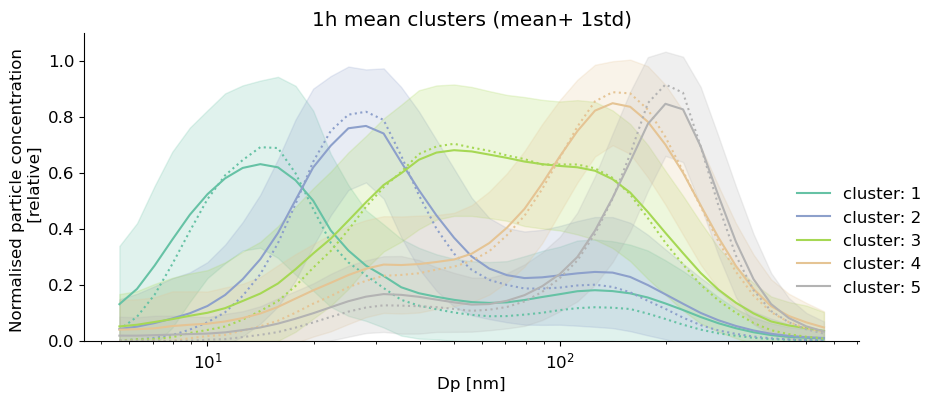

In [15]:
fu.plotClustersNormalized(df_norm_clustered_1h_mean, diameters,
                          df_norm_clustered_1h_mean_mean, df_norm_clustered_1h_std,
                          df_norm_clustered_1h_mean_median)

**Figure 3. The resulting mean (solid line) and standard deviation (shaded) normalized sizedistribution clusters for $k$ = 5. The median is shown as a dotted line.** 

## Comparison of NPF indicators

**OBS!!!!! Changed cpc mass, now diff is above zero!!! UF cpc measure above acyually, see regression in first messy script. Fix legend integration**

To make a simple comparison between the three methods used to identify NPF events (CPC-approaches, integration method and clustering) the annual cycle of the three proxies is shown below. 

In the top panel the results from the absolute difference CPC method are shown, and mid panel shows the difference between the CPC:s. For some instances one of the CPC's appear not have been in operation as it showed zero values while DMPS or other CPC was in operation. Therefore for these occasions where one CPC equals zero, the data is excluded. In the midpanel the integration method results for a diameter threshold diameter of 10 nm is shown and indicated by the black dashed line, and the shaded area shows the 10 and 90 percentiles of the data. Note that this variable is plotted on the right y-axis. In the lower panel, the annual cycles plotted as occurrence in hours of the clusters is shown. The cluster chosen to represent NPF event is cluster 1 and 2 are highlighted. 

From the results in the top panel the absolute difference between CPC:s indicate a reasonable annual NPF cycle (and similar to that of cluster 1,2 and 3), which is in contrast to the difference between the CPC:s. As the same masking was applied to this data as for only taking the difference between the CPCs (mid panel) the absolute difference is likely not a good NPF proxy.

It can be observed that the data in the mid panel displays an annual cycle not typically associated with NPF events at Zeppelin in previous studies (Dall'Osto et al.,2017; Tunved et al., 2013). Their annual trends indicates peak in the dark months associated with Arctic haze and therefore this method is discarded. These indicators are therefore disregarded as NPF indicators. Taking the ration between the UF CPC and normal CPC to identify NPF was also discarded (not shown here) as taking ratios between numbers with small differences makes it hard to discern real differences. Another important conclusion is that the integration method was not successful for the choice of thresholds equal to neither 10,20 or 30 nm (only 10 nm is shown). 

Regarding the clusters in the lower panel, it can be observed that cluster 1 and 2 exhibits annual trends expected for NPF events. However, cluster 3 depicts a similar trend although it was discarded due its very broad size distribution. The accumulation mode clusters (4,5) however follow the expect annual cycle related to the Arctic Haze phenomena. It could also be pointed out that Dall'Osto et al. (2017) produced a similar plot for their NPF indicating clusters indicating similar patterns as for cluster 1-3. With regards to annual cycle (not size distribution), our cluster 1,2,3 depicts a similar trend as to their bursting cluster with peaks in May and close to September, rather than in the middle of the summer which was the case for their nucleation and nascent clusters. It can be concluded that of all studied methods, the clustering method is likely the best proxy for further investigation of NPF events in this project.  
 

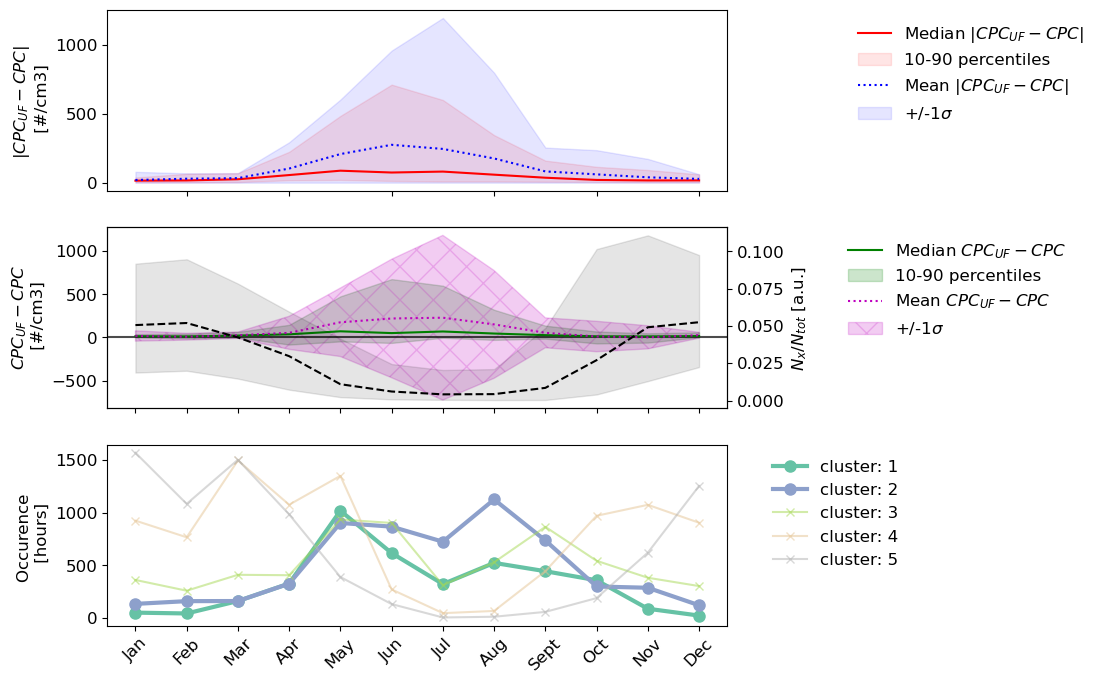

In [16]:
# Input DFs, clusters, threshold = 10 nm for when to integrate
fu.plotNPFproxys(df_hourly_2010_2020_mean,
              df_norm_clustered_1h_mean,
              clusters,
              bin_cols,10,diameters,diameters_as_strings)

**Figure 4. Top panel: The annual cysle of the absolute difference between the UF CPC and CPC 3010. Mid panel: The left axis shows the annual cycle of the difference between the UF CPC and CPC 3010. The right axis shows the results of integrating up to a certain threshold diameter (here 10 nm was chosen). Lower panel: The annual cycle of size distribution cluster 1-5.**

The annual frequency distribution of the clusters is displayed as a normalized stacked bar plot of clusters over the studied years (2010-2020). During the summer months, cluster 1,2 and 3 dominate as opposed to the dark months where the accumulation mode clusters dominate. This strengthens the assumption that cluster 4 and 5 are indicators of Arctic haze and anthropogenic influence (Schmale & Baccarini, 2021). It is evident that cluster 1 and 2 dominate during the summer months. Cluster 3 (not chosen to indicate NPF) appears to follow a similar trend although it is present to higher degree than especially cluster 1 wintertime. However, cluster 3 remains excluded as an NPF proxy due to the shape of its size distribution.

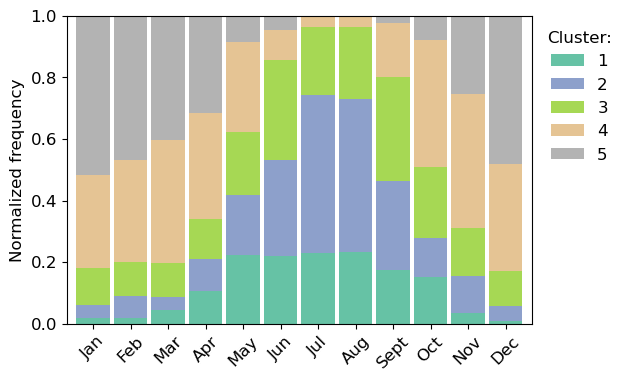

In [17]:
fu.makeStackedPlot(df_norm_clustered_1h_mean,clusters)

**Figure 5. The annual frequency distribution of size distributions cluster 1-5.**

## Trend for NPF events

From the previous results, it can be concluded that the clustering presents the best choice in comparison to the other methods to study trends in NPF at Zeppelin. Potentially it could be interesting to study the trend over the years for the different clusters although such analysis excluded taking into account variation in NPF drivers such as meteorological conditions or variations in NPF precursors or other processes affecting the sources of these such as sea ice extent. We normalized the cluster frequencies to account for data coverage so that cluster occurrence would not be biased. 

First the monthly occurrence needs to be determined for each year and cluster. ``df_clusters_seqMonth_T`` is the transformed version of ``df_clusters_seqMonth`` which contains one row for each sequential month in the dataset, and columns for all the clusters where the occurrence of each cluster is given. It also contains a column which gives the total amount of hours a cluster was represented during this month and the month given by number.
 

In [18]:
df_clusters_seqMonth, df_clusters_seqMonth_T = fu.prepareDFforTrendPlot(df_norm_clustered_1h_mean,clusters)

Choose months of interest in and a dataframe which is normalized for the data coverage for plotting is returned by ``makeDFforTrend``. The months May to July where chosen as this is the time for when the satalitte retirieved chlorophyll has its annual peak (see Keis project). 

In [19]:
# Define the period of interest in terms of months
MJJ_list = [5,6,7]
all_months_list = [1,2,3,4,5,6,7,8,9,10,11,12]

df_norm_MJJ = fu.makeDFforTrend(df_clusters_seqMonth_T,MJJ_list)
df_norm_all = fu.makeDFforTrend(df_clusters_seqMonth_T,all_months_list)

In [20]:
def DFAnnualCountNorm(df_norm_clustered_1h_mean,clusters):
    # Clusters as a number
    
    df = df_norm_clustered_1h_mean.copy(deep=True)
    df['year']  = df.index.year
    #print(df.head())
    
    years = df_norm_all_test['year'].unique() 
    
    # Make a df with sum normalized count per year and cluster
    year_list = []
    year_count_cluster = []  
    
    for year in years:  
        
        # Do it year by year --> slice df
        df_year_sliced = df[df['year'] == year]
        #print(df_year_sliced.head())
        
        df_tmp = df_year_sliced.copy(deep = True)
        
        
        
    # loop over years
    #   Slice on year
    #   Drop all with cluster 1= to cluster 
    #   Make list 
    return 

Below, the Theil-Sen slope and 95% confidence interval is plotted which indicates the trend for the months May, June and July for all clusters between the years 2010 and 2020. The x-axis represents the sequential months (month are counted from the first month of the data set). The Thiel-Sen slope is a non-parametric method to discern trends. This implies that it is robust as the method does not assume that the data is normally distributed. It is best suited to study trends to study periods when there is no influence of seasonality, in that case other methods are preferred. 

No obvious trend can be discerned for any of the clusters, although the data display a varying degree of spread. The trends in satellite data for chlorophyll and sea ice (Kei's work) were shown to be spatially heterogenous for this period. To fully explain the results, additional information is needed, such as airmass origin or trends in aerosol precursors.

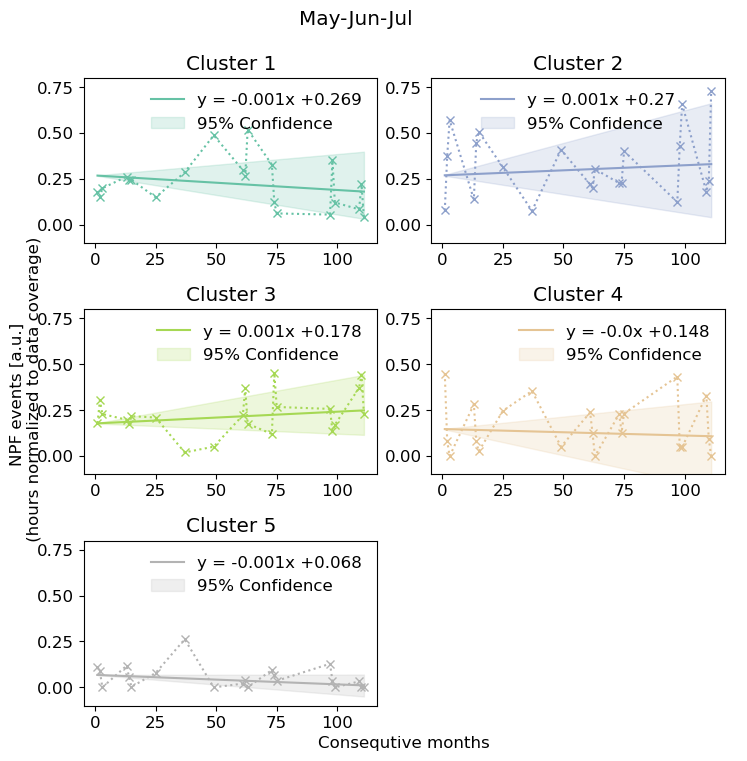

In [24]:
fu.plotThielSen(df_norm_MJJ, clusters,'May-Jun-Jul')

**Figure 5. The 2010-2020 May-June-July trend for cluster 1-5. The x-axis indicates the consequtive months starting from the first measurement point 2010. The (non-parametric) Thiel-Sen slope is used to estimate the trend.**

## NPF relation to sea ice concentration 

Our main aim was to make an attempt at reproducing the results from Dall'Osto et al. (2017) who put forward the hypothesis of an anti-correlation between sea ice extent and NPF frequency, i.e. that decreasing sea ice in the Barents and Greenland Sea promotes NPF. We investigate whether the anti-correlation holds true when more recent data is used from the Zeppelin station. Dall'Osto et al. (2017) investigated the years 2000-2010 and this part of our study encompass 2010-2017 as there was an overlap between DMPS data and sea ice satellite data for this period. Here, the annual sea ice concentration data (Kei's work) in the Barents and Greenland Sea is used instead of sea ice extent. We normalized the NPF observations to data coverage (in order to remove this dependence) from cluster 1 and 2 and use the annual sum of their frequency as those have been chosen as a proxy for NPF events. First, the annual occurrence of cluster 1 and 2 is computed and the sea ice concentration data is loaded.

In [22]:
# Compute the monthly and yearly normalized count for all clusters
df_monthly_cluster_count = df_norm_all.copy(deep = True)
df_yearly_count_clusters = fu.DFAnnualCount(df_norm_all,clusters)

# Compute the total normlized count for cluster 1 and 2 by adding extra column and removing other clusters (=3,4,5)
monthly_cluster_count_12, df_yearly_cluster_count_12 = fu.sumCluster12(df_monthly_cluster_count,df_yearly_count_clusters)
sea_ice_annual = fu.readSeaIcetoDF()

The results shown below gives little confidence in the hypothesis that NPF at Zeppelin is anti-correlated with sea ice concentration in the studied region between 2010-2017 ($R^2$ = 0.21, $p$ = 0.25). The p-value is the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero (no correlation). The calculated p-value and $R^2$ is not enough to reject this null-hypothesis. There are several explanations that are possible for this. For example, the sample size is quite low, or there is simply no correlation between sea ice concentration in the studied region and NPF, but that does not means changes in other NPF drivers have not occurred simultaneously or in other regions which have an effect on NPF drivers. Furthermore, it may be that the 1h-clusters to represent NPF events chosen do not capture the NPF events properly.  

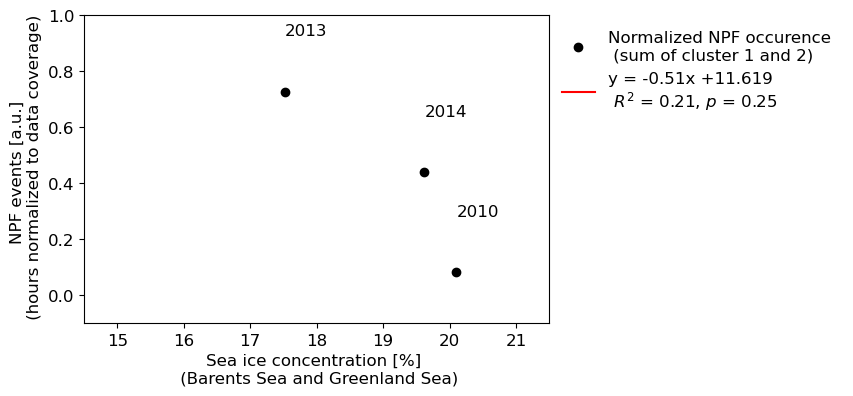

In [23]:
fu.plotNPFvsSeaIce(sea_ice_annual,df_yearly_cluster_count_12)

**Figure 6. The 2010-2017 (normalized) total annual frequency of cluster 1 and 2 versus sea ice concentration in the Greenland and Barents Sea.**

# Discussion
NPF is an import source of CCN in the Arctic where clouds exert a net warming effect.  However, the process driving NPF, and cloud droplet response are complex (Birch et al., 2012). The main objective of this project was to examine if the conclusions from Dall’Osto et al. (2017) holds true for more recent years, i.e. that there is a causal relationship between sea ice loss and NPF at the Zeppelin station located in the Arctic for. A second objective was to investigate different methods for identification of NPF events. 

To investigate the effect of sea ice melt on NPF frequency, the identification of NPF events is crucial. Here, the K-means clustering presented the best option in comparison to other methods that were tested. However, using unsupervised machine learning implies little insight to the actual clustering procedure. Two metrics were used to evaluate the performance of the clustering, but several others are available which might affect the choice of $k$ which is crucial to our analysis. The Dunn Index for example provides information how compact and well separated clusters. The higher the Dunn Index, the better. Dall’Osto et al. (2017) computed the Dunn Index and average silhouette score for their clusters, but their calculated Dunn index was close to zero (see supplement) meaning that clusters on average are not well separated. In this work we faced similar issues (although the Dunn Index was not calculated) but the inertia and average silhouette score calculation results were hard to clearly draw conclusions on the optimal cluster number from. 

Even though the clustering method may not be optimal, the results present some interesting features. For example, the bimodality of some of the clusters in our clustered 2010-2020 DMPS data was not as prounounced in the work of Dall'Osto et al. It could be speculated (if we decide to trust our method blindly) weather the bimodality and cluster 3 which follows the same annual trend as the NPF cluster (1 and 2), suppresses the NPF formation by providing an additional condensation sink, and therefore we are unable to reproduce the anticorrelation of NPF and sea ice presented by Dall’Osto et al. (2017).

We found no evidence of an anti-correlation between NPF and sea ice concentration. A direct comparison is impaired by the different years Dall’Osto et al.’s study and ours target. Moreover, it is unclear weather their NPF frequency was adjusted for data coverage. The relationship between NPF and air mass origin is also something that needs to be accounted for, as marine air masses that contribute to NPF may come from regions unaffected by sea ice melt. Mixed and spatially heterogenoues trends in chlorophyll satellite data which is indicator of microbiological activity (and source of NPF precursor gases) emphasizes the need for back trajectory analysis in our work. 


# Conclusions and outlook
We observed no trends for individual DMPS clusters, nor an anti-correlation of NPF to sea ice concentration in the Barents and Greenland Sea. As Kei found that trends are spatially heterogeneous for chlorophyll and sea ice concentration, back trajectory analysis would provide valuable insight into the driving forces of NPF event at Zeppelin in a rapidly warming Arctic.

For future work a more careful cluster optimization is advised. Other features of the size distributions than shape, such as modal diameter or width could also be extracted clustered. Another aspect of sea ice loss is a presumed increase in anthropogenic activity in the Arctic such as increased shipping. Looking into to changes in this over the last twenty years could also help with the task of identifying what drives NPF at Zeppelin.


# References

Birch, C. E., Brooks, I. M., Tjernström, M., Shupe, M. D., Mauritsen, T., Sedlar, J., ... & Leck, C. (2012). Modelling atmospheric structure, cloud and their response to CCN in the central Arctic: ASCOS case studies. Atmospheric Chemistry and Physics, 12(7), 3419-3435.

Dall´Osto, M., Beddows, D., Tunved, P. et al. Arctic sea ice melt leads to atmospheric new particle formation. Sci Rep 7, 3318 (2017). https://doi.org/10.1038/s41598-017-03328-1

Galí, M., Devred, E., Babin, M., & Levasseur, M. (2019). Decadal increase in Arctic dimethylsulfide emission. Proceedings of the National 
Academy of Sciences of the United States of America, 116(39), 19311–19317. https://doi.org/10.1073/pnas.1904378116

Schmale, J., & Baccarini, A. (2021). Progress in unraveling atmospheric new particle formation and growth across the Arctic. Geophysical Research Letters, 48(14), e2021GL094198.

Tunved, P., Ström, J. & Krejci, R. Arctic aerosol life cycle: linking aerosol size distributions observed between 2000 and 2010 with air mass transport and precipitation at Zeppelin station, Ny-Ålesund, Svalbard. Atmos. Chem. Phys. 13, 3643–3660 (2013).

Perovich, D., Meier, W., Tschudi, M., Farrell, S., Hendricks, S., Gerland, S., ... & Webster, M. (2018). Sea ice. NOAA Arctic Report Card.